In [1]:
# SKIP THIS IF YOU WANT TO USE THE NON WEB INTERFACE (can only be done when notebook run locally)
%matplotlib inline

In [2]:
#%%
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')
    print(1)
except:
    print('NOT IPYTHON')

import sys
import numpy as np
from scipy.sparse import coo_matrix
import tifffile
from time import time
import psutil
from scipy.ndimage.filters import gaussian_filter
from ipyparallel import Client

import caiman as cm
from caiman.utils.visualization import plot_contours,nb_plot_contour,nb_view_patches3d
import caiman.source_extraction.cnmf as cnmf
from caiman.source_extraction.cnmf.utilities import order_components

from matplotlib import pyplot as plt
import bokeh.plotting as bpl
from IPython.display import clear_output
bpl.output_notebook()

1
numba not found


Loading BokehJS ...

In [3]:
#%%
n_processes = np.maximum(np.int(psutil.cpu_count()*.9),1) # roughly number of cores on your machine minus 1
print('using ' + str(n_processes) + ' processes')
print("Stopping  cluster to avoid unnencessary use of memory....")
sys.stdout.flush()  
cm.stop_server()

using 21 processes
Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
NOT SLURM
No cluster to stop... done


In [4]:
def gen_data(p = 1, noise=1., T=256, framerate=30, firerate=2., plot=False):
    if p==2:
        gamma = np.array([1.5,-.55])
    elif p==1:
        gamma = np.array([.9])
    else: raise
    dims = (30, 40, 50)  # size of image
    sig = (2, 2, 2)  # neurons size
    bkgrd = 10
    N = 20  # number of neurons
    np.random.seed(7)
    centers = np.asarray([[np.random.randint(5,x-5) 
                           for x in dims] for i in range(N)])
    Yr = np.zeros(dims + (T,), dtype=np.float32)
    trueSpikes = np.random.rand(N,T) < firerate / float(framerate)
    trueSpikes[:,0] = 0
    truth = trueSpikes.astype(np.float32)
    for i in range(2,T):
        if p ==2:
            truth[:,i] += gamma[0]*truth[:,i-1] + gamma[1]*truth[:,i-2] 
        else:
            truth[:,i] += gamma[0]*truth[:,i-1]
    for i in range(N):
        Yr[centers[i,0],centers[i,1],centers[i,2]] = truth[i]
    tmp=np.zeros(dims)
    tmp[15,20,25]=1.
    z=np.linalg.norm(gaussian_filter(tmp, sig).ravel())
    Yr = bkgrd + noise * np.random.randn(*(dims + (T,))) + 10 *gaussian_filter(Yr, sig + (0,)) /z
    d1,d2,d3,T=Yr.shape
    Yr=np.reshape(Yr,(d1*d2*d3,T),order='F').astype(np.float32)
 
    if plot:
        Y=np.reshape(Yr,(d1,d2,d3,T),order='F')
        Cn = cm.local_correlations(Y)
        plt.figure(figsize=(15,3))
        plt.plot(truth.T);
        plt.figure(figsize=(15,3))
        for c in centers:
            plt.plot(Y[c[0],c[1],c[2]]);

        plt.figure(figsize=(15,4))
        plt.subplot(131)
        plt.scatter(*centers.T[::-1],c='g')
        plt.imshow(Y.max(0).max(-1),cmap='hot');plt.title('Max.proj. x & t')
        plt.subplot(132)
        plt.scatter(*centers.T[[2,0,1]],c='g')
        plt.imshow(Y.max(1).max(-1),cmap='hot');plt.title('Max.proj. y & t')
        plt.subplot(133)
        plt.scatter(*centers.T[[1,0,2]],c='g')
        plt.imshow(Y.max(2).max(-1),cmap='hot');plt.title('Max.proj. z & t')
        plt.show()
        
    return Yr, truth, trueSpikes, centers, dims

In [5]:
plt.close('all')
#%% SAVING TIFF FILE ON A SINGLE MEMORY MAPPABLE FILE
try:
    fname_new=cm.save_memmap(['/rugpfs/fs0/vzri_lab/scratch/sweisenbur/data/mouse01_volume02_41planes_2500t.tif'],base_name='Yr',is_3D=True)
except: #%% create 3d tiff file if not yet existent
    Yr, truth, trueSpikes, centers, dims = gen_data(p=2)
    # imagej takes data shapes up to 6 dimensions in TZCYXS order
    data = np.transpose(Yr.reshape(dims+(-1,1), order='F'), [3, 0, 4, 1, 2])
    t = tifffile.TiffWriter('example_movies/demoMovie3D.tif', imagej=True)
    t.save(data)
    t.close()
    fname_new=cm.save_memmap(['example_movies/demoMovie3D.tif'],base_name='Yr',is_3D=True)

print(fname_new)

/rugpfs/fs0/vzri_lab/scratch/sweisenbur/data/mouse01_volume02_41planes_2500t.tif
/rugpfs/fs0/vzri_lab/scratch/sweisenbur/data/Yr_d1_41_d2_100_d3_112_order_F_frames_2500_.mmap


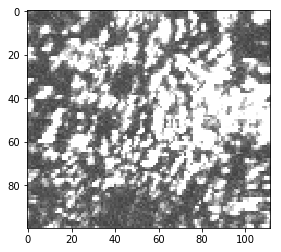

In [6]:
Yr,dims,T=cm.load_memmap(fname_new)
Y=np.reshape(Yr,dims+(T,),order='F')
Cn = cm.local_correlations(Y)
plt.imshow(Cn.max(0) if len(Cn.shape)==3 else Cn, cmap='gray',vmin=np.percentile(Cn, 1), vmax=np.percentile(Cn, 99))    
plt.show()

In [7]:
#%%
K=10000 # number of neurons expected per patch
gSig=[2,2,1] # expected half size of neurons
merge_thresh=0.8 # merging threshold, max correlation allowed
p=1 #order of the autoregressive system
options = cnmf.utilities.CNMFSetParms(Y,n_processes,p=p,gSig=gSig,K=K)
cm.start_server()
c=Client()

using 21 processes
using 1000 pixels per process
using 1000 block_size
Starting cluster...

/ru-auth/local/home/sweisenbur/anaconda2/envs/nmf/lib/python2.7/site-packages/ipyparallel/client/client.py:442: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@172.31.4.157')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


.

In [8]:
#%% PREPROCESS DATA AND INITIALIZE COMPONENTS
t1 = time()
Yr,sn,g,psx = cnmf.pre_processing.preprocess_data(Yr,dview=c[:],**options['preprocess_params'])
Atmp, Ctmp, b_in, f_in, center=cnmf.initialization.initialize_components(Y, **options['init_params'])                                                    
print(time() - t1)

checking if missing data
Running on 24 engines.
Noise Normalization
Spatial Downsampling ...
Roi Extraction...


/ru-auth/local/home/sweisenbur/anaconda2/envs/nmf/lib/python2.7/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in divide
  return a / b


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
options['init_params']['tsub']=10
options['init_params']['ssub']=1
print(options['init_params'])

In [ ]:
refine_components=False
if refine_components:
    Ain,Cin = manually_refine_components(Y,options['init_params']['gSig'],coo_matrix(Atmp),Ctmp,Cn,thr=0.9)
else:
    Ain,Cin = Atmp, Ctmp

In [ ]:
plt.close('all')
Ain.shape

In [ ]:
p1=nb_plot_contour(Cn.max(0),Ain.reshape(dims+(-1,),order='F').max(0).reshape((-1,K),order='F'),
                       dims[1],dims[2],face_color=None, line_color='black',alpha=0.4,line_width=2)
#bpl.show(p1)

In [ ]:
options['spatial_params']['thr_method']='nrg'
options['spatial_params']['extract_cc']=False
print(options['spatial_params'])

In [ ]:
#%% UPDATE SPATIAL COMPONENTS
t1 = time()
A,b,Cin = cnmf.spatial.update_spatial_components(Yr, Cin, f_in, Ain, sn=sn, **options['spatial_params'])
t_elSPATIAL = time() - t1
print(t_elSPATIAL) 
#clear_output(wait=True)
print('DONE!')

In [ ]:
plt.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
crd = plot_contours(
    A.toarray().reshape(dims+(-1,),order='F').max(0).reshape((np.prod(dims[1:]),-1),order='F'),
                       Cn.max(0), thr_method='max')
#plt.show()

In [ ]:
plt.close('all')

In [ ]:
p1=nb_plot_contour(Cn.max(0),A.toarray().reshape(dims+(-1,),order='F').max(0)
                   .reshape((np.prod(dims[1:]),-1),order='F'),
                   dims[1],dims[2],face_color=None, line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

In [ ]:
plt.close()
t1 = time()
options['temporal_params']['p'] = 0 # set this to zero for fast updating without deconvolution
C,f,S,bl,c1,neurons_sn,g,YrA = cnmf.temporal.update_temporal_components(Yr,A,b,Cin,f_in,bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
t_elTEMPORAL = time() - t1
print(t_elTEMPORAL)  
clear_output(wait=True)

In [ ]:
#%% merge components corresponding to the same neuron
t1 = time()
A_m,C_m,nr_m,merged_ROIs,S_m,bl_m,c1_m,sn_m,g_m=cnmf.merging.merge_components(Yr,A,b,C,f,S,sn,options['temporal_params'], options['spatial_params'], bl=bl, c1=c1, sn=neurons_sn, g=g, thr=0.8, mx=50, fast_merge = True)
t_elMERGE = time() - t1
print(t_elMERGE)  

In [ ]:
#refine spatial and temporal components
t1 = time()
A2,b2,C2 = cnmf.spatial.update_spatial_components(Yr, C_m, f, A_m, sn=sn, **options['spatial_params'])
options['temporal_params']['p'] = p # set it back to original value to perform full deconvolution
options['temporal_params']['bas_nonneg'] = False
C2,f2,S2,bl2,c12,neurons_sn2,g21,YrA = cnmf.temporal.update_temporal_components(Yr,A2,b2,C2,f,dview = c[:],bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
print(time() - t1)
clear_output(wait=True)
print(time() - t1)
print('DONE!')

In [ ]:
A_or, C_or, srt = order_components(A2,C2)

In [ ]:
plt.figure(num=None, figsize=(9, 7), dpi=600, facecolor='w', edgecolor='k')
traces_neurons=plt.pcolor(C_or, cmap='jet', vmin=0, vmax=0.2)
plt.colorbar(traces_neurons)
plt.gca().invert_yaxis()
plt.xlabel('Time (frame)')
plt.ylabel('Neuron')
#cbar.set_label('Df/f')
#plt.show(traces_neurons)

In [ ]:
#%% SAVE DATA
import h5py
with h5py.File('../data/test-results.h5', 'w') as hf:
    hf.create_dataset("C_or",  data=C_or)
    hf.create_dataset("f2",  data=f2)
    hf.create_dataset("b2",  data=b2)

In [ ]:
#%% STOP CLUSTER
cm.stop_server()